In [10]:
from torchvision import transforms
import torchvision
import cv2
import skimage.io as io
from PIL import Image
import torch
from torch import nn
import os
from datetime import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import json
from glob import glob
import sys
import datetime
from torchvision.utils import save_image


import pandas as pd
from skimage.transform import resize
import SimpleITK as itk

In [2]:
RANDOM_SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

In [5]:
with open('../configs/ventricle.json') as f:
    config = json.load(f)

In [14]:
encode_qualities = {'Good': np.array([0, 0, 1]), 'Medium': np.array([0, 1, 0]), 'Poor': np.array([1, 0, 0])}
encode_heart_states = {'ES': np.array([1, 0]), 'ED': np.array([0, 1])}
encode_views = {'2CH': np.array([1, 0]), '4CH': np.array([0, 1])}

In [63]:
class DatasetCAMUS(Dataset):

    def __init__(self,
                 dataset_path='/home/vasily/datasets/us_camus/',
                 img_size=(256, 256),
                 classes={0, 1, 2, 3},
                 heart_states={'ED', 'ES'},
                 views={'2CH', '4CH'},
                 image_qualities={'Good', 'Medium', 'Poor'},
                 patient_qualities={'Good', 'Medium', 'Poor'},
                 random_state=17,
                 train_ratio=None,
                 valid_ratio=None,
                 #                  test_size=0.2,
                 folds=None,
                 shuffle=True,
                 #                  lv_crop_ratio=1.2,
                 #                  lv_crop_aspect_ratio=.5,
                 subset='train'
                 ):

        np.random.seed(random_state)
        self.random_state = random_state
        self.shuffle = shuffle
        self.dataset_path = os.path.join(dataset_path, 'training')
        self.img_size = img_size
        self.classes = classes
        self.heart_states = heart_states
        self.views = views
        self.image_qualities = image_qualities
        self.patient_qualities = patient_qualities
        self.subset = subset

        if folds:
            self.num_folds = max(0, folds)
        else:
            self.num_folds = None
            if train_ratio:
                self.train_ratio = train_ratio
                if valid_ratio:
                    self.valid_ratio = valid_ratio
                    self.test_ratio = 1 - train_ratio - valid_ratio
                else:
                    self.valid_ratio = 0
                    self.test_ratio = 1 - train_ratio
            else:
                self.train_ratio = 1
                self.valid_ratio = 0
                self.test_ratio = 0

        self.get_dataset_info()
        self.calculate_stat()

    def get_dataset_info(self):
        ends = [
            '_2CH_ED.mhd', '_2CH_ED_gt.mhd', '_2CH_ES.mhd', '_2CH_ES_gt.mhd', '_4CH_ED.mhd', '_4CH_ED_gt.mhd',
            '_4CH_ES.mhd', '_4CH_ES_gt.mhd',
            '_2CH_ED.raw', '_2CH_ED_gt.raw', '_2CH_ES.raw', '_2CH_ES_gt.raw', '_4CH_ED.raw', '_4CH_ED_gt.raw',
            '_4CH_ES.raw', '_4CH_ES_gt.raw',
        ]

        self.df_images = pd.DataFrame(
            columns=['patient', 'heart_state', 'view', 'quality', 'img_shape', 'img_name', 'msk_name'])
        self.df_patients = pd.DataFrame(columns=['patient', 'ef', 'quality'])

        for patient in np.sort(os.listdir(self.dataset_path)):
            patient_files = os.listdir(os.path.join(self.dataset_path, patient))
            if not patient_files:
                continue

            for file in [patient + it for it in ends]:
                if file not in patient_files:
                    print('There is no file in folder of ' + patient)
                    return

            if 'Info_2CH.cfg' not in patient_files or 'Info_4CH.cfg' not in patient_files:
                print('There is no cfg file in folder of ' + patient)
                return

            #  Read cfg 2CH
            f = open(os.path.join(self.dataset_path, patient, 'Info_2CH.cfg'))
            for it in f.readlines():
                if it.startswith('ImageQuality'):
                    quality_2ch = it.split()[-1]
                elif it.startswith('LVef'):
                    ef_2ch = it.split()[-1]

            #  Read cfg 4CH
            f = open(os.path.join(self.dataset_path, patient, 'Info_4CH.cfg'))
            for it in f.readlines():
                if it.startswith('ImageQuality'):
                    quality_4ch = it.split()[-1]
                elif it.startswith('LVef'):
                    ef_4ch = it.split()[-1]

            if quality_2ch == 'Poor' or quality_4ch == 'Poor':
                pat_quality = 'Poor'
            elif quality_2ch == 'Medium' or quality_4ch == 'Medium':
                pat_quality = 'Medium'
            elif quality_2ch == 'Good' or quality_4ch == 'Good':
                pat_quality = 'Good'

            if ef_2ch != ef_4ch:
                print('Problems with EF')

            self.df_patients = self.df_patients.append({'patient': patient,
                                                        'quality': pat_quality,
                                                        'ef': float(ef_2ch),
                                                        }, ignore_index=True)

            img_shapes = []
            f = open(os.path.join(self.dataset_path, patient, patient + '_2CH_ED.mhd'))
            img_shapes.append(
                tuple(map(int, sum([it.split()[-3:-1] for it in f.readlines() if it.startswith('DimSize')], []))))
            f = open(os.path.join(self.dataset_path, patient, patient + '_2CH_ES.mhd'))
            img_shapes.append(
                tuple(map(int, sum([it.split()[-3:-1] for it in f.readlines() if it.startswith('DimSize')], []))))
            f = open(os.path.join(self.dataset_path, patient, patient + '_4CH_ED.mhd'))
            img_shapes.append(
                tuple(map(int, sum([it.split()[-3:-1] for it in f.readlines() if it.startswith('DimSize')], []))))
            f = open(os.path.join(self.dataset_path, patient, patient + '_4CH_ES.mhd'))
            img_shapes.append(
                tuple(map(int, sum([it.split()[-3:-1] for it in f.readlines() if it.startswith('DimSize')], []))))

            df = pd.DataFrame.from_dict(({'patient': [patient, patient, patient, patient],
                                          'heart_state': ['ED', 'ES', 'ED', 'ES'],
                                          'view': ['2CH', '2CH', '4CH', '4CH'],
                                          'quality': [quality_2ch, quality_2ch, quality_4ch, quality_4ch],
                                          'img_shape': img_shapes,
                                          'img_name': [patient + it for it in
                                                       ['_2CH_ED.mhd', '_2CH_ES.mhd', '_4CH_ED.mhd', '_4CH_ES.mhd']],
                                          'msk_name': [patient + it for it in
                                                       ['_2CH_ED_gt.mhd', '_2CH_ES_gt.mhd', '_4CH_ED_gt.mhd',
                                                        '_4CH_ES_gt.mhd']],
                                          }))

            self.df_images = self.df_images.append(df, ignore_index=True)

        if self.shuffle:
            self.df_images = self.df_images.sample(frac=1, random_state=self.random_state)

        self.df_patients = self.df_patients[self.df_patients['quality'].isin(self.patient_qualities)]
        self.df_images = self.df_images[self.df_images['patient'].isin(self.df_patients['patient'].values)]
        self.df_images = self.df_images[self.df_images['quality'].isin(self.image_qualities)]
        self.df_images = self.df_images[self.df_images['heart_state'].isin(self.heart_states)]
        self.df_images = self.df_images[self.df_images['view'].isin(self.views)]

        # Разбиение по фолдам
        if self.num_folds:
            self.df_patients['fold'] = None
            self.num_patient_in_fold = self.df_patients['quality'].value_counts() / self.num_folds
            for fold in range(self.num_folds):
                count = {'Good': 0, 'Medium': 0, 'Poor': 0}
                for index, row in self.df_patients.iterrows():
                    if not pd.isna(row['fold']):
                        continue
                    quality = row['quality']
                    if count[quality] < self.num_patient_in_fold[quality]:
                        count[quality] += 1
                        self.df_patients['fold'].at[index] = fold
                    if sum(list(count.values())) == 50:
                        break

        if self.train_ratio:
            self.train_df_images = self.df_images[:int(self.train_ratio * len(self.df_images))]
            self.valid_df_images = self.df_images[int(self.train_ratio * len(self.df_images)):int(
                self.train_ratio * len(self.df_images) + self.valid_ratio * len(self.df_images))]
            self.test_df_images = self.df_images[
                                  int(self.train_ratio * len(self.df_images) + self.valid_ratio * len(self.df_images)):]

    def calculate_stat(self):
        #  Вычисление статистик по набору данных
        self.ef_dist = {'<=45': 0, '>=55': 0, 'else': 0}
        self.ef_dist['<=45'] = len(self.df_patients[(self.df_patients['ef'] <= 45)]) / len(self.df_patients)
        self.ef_dist['>=55'] = len(self.df_patients[(self.df_patients['ef'] >= 55)]) / len(self.df_patients)
        self.ef_dist['else'] = len(
            self.df_patients[(self.df_patients['ef'] > 45) & (self.df_patients['ef'] < 55)]) / len(self.df_patients)

        self.quality_dist = dict(self.df_patients['quality'].value_counts() / len(self.df_patients))

        self.ef_fold_dist = {}
        if self.num_folds:
            for fold in range(self.num_folds):
                self.ef_fold_dist[fold] = {'<=45': 0, '>=55': 0, 'else': 0}
                self.ef_fold_dist[fold]['<=45'] = len(
                    self.df_patients[(self.df_patients['fold'] == fold) & (self.df_patients['ef'] <= 45)]) / len(
                    self.df_patients) * self.num_folds
                self.ef_fold_dist[fold]['>=55'] = len(
                    self.df_patients[(self.df_patients['fold'] == fold) & (self.df_patients['ef'] >= 55)]) / len(
                    self.df_patients) * self.num_folds
                self.ef_fold_dist[fold]['else'] = len(self.df_patients[(self.df_patients['fold'] == fold) & (
                        self.df_patients['ef'] > 45) & (self.df_patients['ef'] < 55)]) / len(
                    self.df_patients) * self.num_folds

            for fold in range(self.num_folds):
                self.quality_fold_dist = dict(
                    self.df_patients[self.df_patients['fold'] == fold]['quality'].value_counts() / len(
                        self.df_patients) * self.num_folds)

    def set_state(self, subset, fold=None):
        self.subset = subset

    def read_mhd(self, img_path):
        image_itk = itk.ReadImage(img_path)
        image = itk.GetArrayFromImage(image_itk)
        return np.squeeze(image)
    def get_circle_sector(img):
        mask = img != 1
        return mask

    def get_weight_map(self, mask):
        # let the y axis have higher variance
        gauss_var = [[self.img_size[0] * 60, 0], [0, self.img_size[1] * 30]]
        # print(mask.shape) # (256, 256) or (256, 256, 1) for empty
        # if len(mask.shape) > 2:
        #    mask = np.squeeze(mask, axis=2)
        #
        x, y = mask.nonzero()

        center = [x.mean(), y.mean()]

        from scipy.stats import multivariate_normal
        gauss = multivariate_normal.pdf(np.mgrid[
                                        0:self.img_size[1],
                                        0:self.img_size[0]].reshape(2, -1).transpose(),
                                        mean=center,
                                        cov=gauss_var)

        gauss /= gauss.max()
        gauss = gauss.reshape((self.img_size[1], self.img_size[0]))

        # set the gauss value of the main target part to 1
        gauss[mask > 0] = 1

        return gauss

    def __len__(self):
        if self.subset == 'train':
            return len(self.train_df_images)
        elif self.subset == 'valid':
            return len(self.valid_df_images)
        elif self.subset == 'test':
            return len(self.test_df_images)

    def __getitem__(self, index):
        if self.subset == 'train':
            obj = self.train_df_images.iloc[index]
        elif self.subset == 'valid':
            obj = self.valid_df_images.iloc[index]
        elif self.subset == 'test':
            obj = self.test_df_images.iloc[index]

        image = self.read_mhd(os.path.join(self.dataset_path, obj['patient'], obj['img_name']))
        image = resize(image, self.img_size, order=1)
        
        
        
        
        full_mask = self.read_mhd(os.path.join(self.dataset_path, obj['patient'], obj['msk_name']))
        full_mask = resize(full_mask, self.img_size, preserve_range=True, anti_aliasing=False, order=0)

        quality = encode_qualities[obj['quality']]
        heart_state = encode_heart_states[obj['heart_state']]
        view = encode_views[obj['view']]

        mask = full_mask.copy()
        for not_l in {0, 1, 2, 3} - set(self.classes):
            mask[mask == not_l] = 0

        weight_map = self.get_weight_map(mask)
        segment_mask = image != 0
        
        image = torch.tensor(image).float().unsqueeze(dim=0)
        
        
        
        mask = torch.tensor(mask).float().unsqueeze(dim=0)
        full_mask = torch.tensor(full_mask).float().unsqueeze(dim=0)
        weight_map = torch.tensor(weight_map).float().unsqueeze(dim=0)
        segment_mask = torch.tensor(segment_mask).float().unsqueeze(dim=0)
        
        
        
        
        quality = torch.tensor(quality).long().unsqueeze(dim=0)
        heart_state = torch.tensor(heart_state).long().unsqueeze(dim=0)
        view = torch.tensor(view).long().unsqueeze(dim=0)
        
        return image, mask, full_mask, weight_map, segment_mask, quality, heart_state, view

In [64]:
dataset_path = '/home/euloo/Documents/datasets/CAMUS'

In [65]:
train_data = DatasetCAMUS(dataset_path=dataset_path,
                                       random_state=config['RANDOM_SEED'],
                                       img_size=config['IMAGE_RES'],
                                       classes=config['LABELS'],
                                       train_ratio=config['TRAIN_RATIO'],
                                       valid_ratio=config['VALID_RATIO'],
                                       heart_states=config['HEART_STATES'],
                                       views=config['HEART_VIEWS'],
                                       image_qualities=config['IMAGE_QUALITIES'],
                                       patient_qualities=config['PATIENT_QUALITIES'],
                                       # augment=self.augmentation,
                                       subset='train')

In [66]:
train_data.__len__()

427

In [67]:
image, mask, full_mask, weight_map, segment_mask, quality, heart_state, view = train_data[0]

In [38]:
segment_mask.shape

torch.Size([1, 256, 256])

In [40]:
segment_mask[0].shape

torch.Size([256, 256])

In [69]:
segment_mask[0].min(), segment_mask[0].max()

(tensor(0.), tensor(1.))

In [41]:
256 * 256

65536

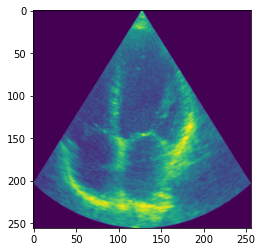

In [44]:
plt.imshow(segment_mask[0] * image[0])

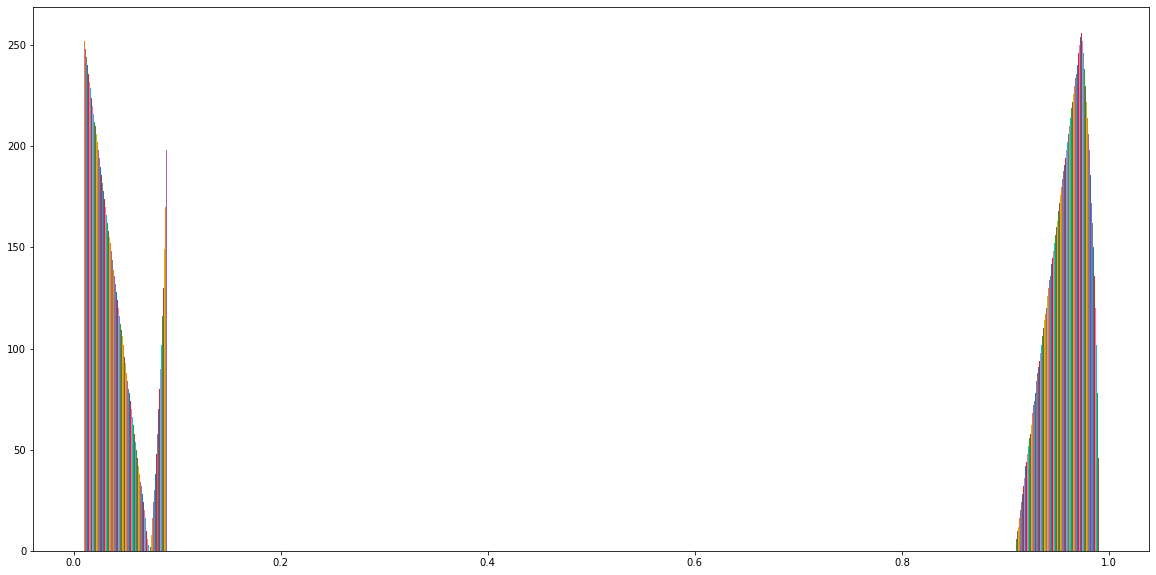

In [73]:
plt.figure(figsize=(20,10))
plt.hist(segment_mask[0]);

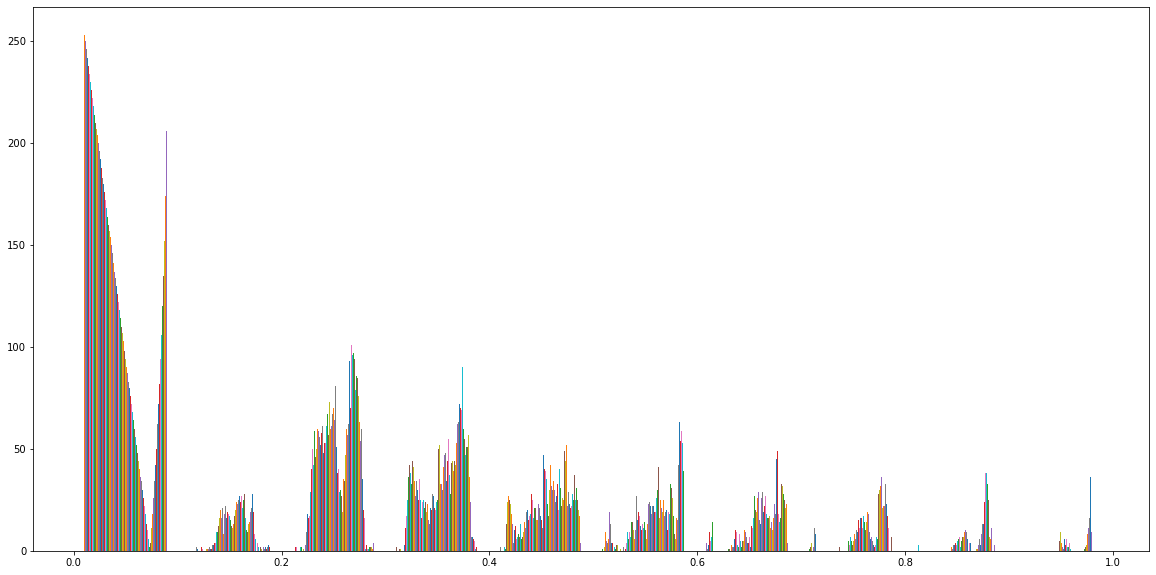

In [50]:
plt.figure(figsize=(20,10))
plt.hist(image[0]);

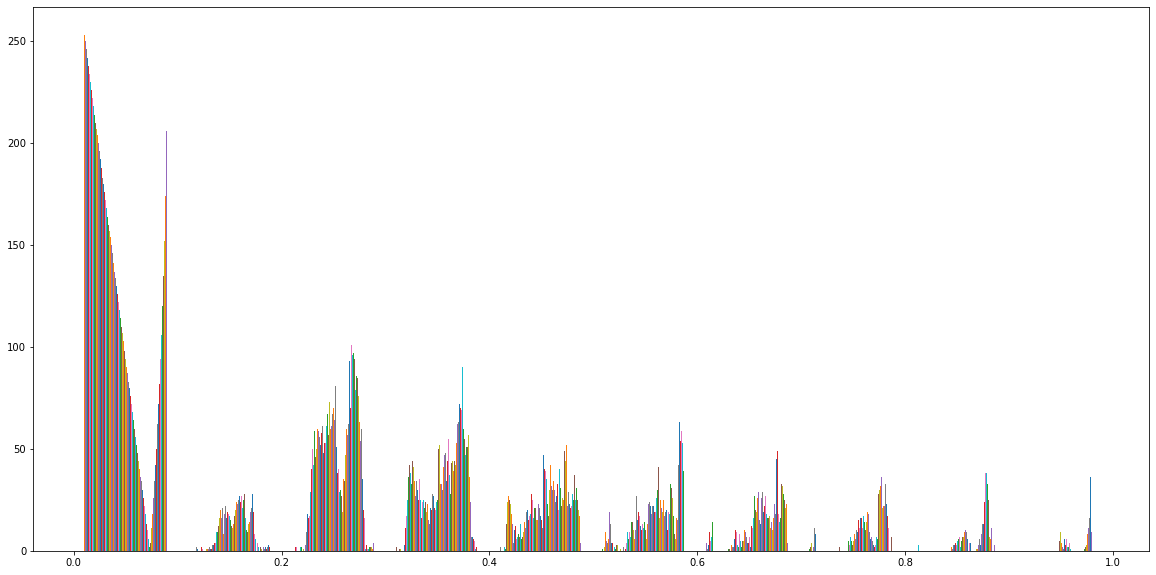

In [52]:
plt.figure(figsize=(20,10))
plt.hist(segment_mask[0] * image[0]);